In [ ]:
# To reduce the number of times this peace of code might be run
# (when not necessary), it is kept in its ow cell seperate from other imports
# necessary to run the model training and evaluation
from google.colab import drive

drive.mount("/content/MyDrive")

# read in the file and close the file stream
explicit_pic_urls_file = open("/content/MyDrive/MyDrive/ecd-project/pic-urls.txt", "r")
explicit_pics_urls = explicit_pic_urls_file.readlines()
explicit_pic_urls_file.close()
neutral_pics_files = open("/content/MyDrive/MyDrive/ecd-project/neutral-urls.txt")
neutral_pics_urls = neutral_pics_files.readlines()
neutral_pics_files.close()

Mounted at /content/MyDrive


In [ ]:
import imageio
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from matplotlib import pyplot as plt
from tqdm import tqdm

## Preprocessing Algorithm
Preprocessign mainly involved:
```
- Start
- let viable_pictures <- emptylist[]
- trainable_list = empty_list()
- for url in pic_urls:
    - if isActive(url):
        viable_pictures.append(url)
      else:
          continue

- for pic in viable_pictures:
    matrix_form = convert_to_matrix(pic)
    new_pic = resize(matrix_form, 100) # maintains ratio
    new_pic = center_crop(new_pic)
    trainable_list.append(new_pic)
- end
```

## Creation of the Datasets
- Shuffled all the pictures
- seperated them into two parts:
    - the larger constituted of (n - 2000) images
    - the training dataset consisted of 2000 images

In [ ]:
# this array stores all the valid pictures in form of np matrices that can be
# used to train the model
trainable_data = []
neutral_trainable_data = []

img_transfroms = transforms.Compose([
    transforms.Resize(100),
    transforms.CenterCrop(100),
])

def fetch_images(dataset_urls, dataset, expected_output, transform, size):
  # Download the explict image
  for i in tqdm(range(size)):
    # this try-except block catched all the HttpError that are as a result of a
    # dead-link (404) or any other status code except 200 (OK)
    try:
      img = imageio.imread(dataset_urls[i])
      # this try-except block is used to capture the images that have been removed
      # this is shown by an np.matrix that is shape (81, 161) which declares
      # such.
      try:
        h, w, c = img.shape
        if c == 3:
          image = transform(
              torch.tensor(img, dtype=torch.float32).permute(2, 0, 1))
          output = torch.tensor(expected_output)
          new_image = torch.tensor(image.numpy(), dtype=torch.float32)
          dataset.append((new_image, output))
      except:
        pass
    except:
      pass

fetch_images(
    explicit_pics_urls, trainable_data, 0, img_transfroms, 20000)
fetch_images(
    neutral_pics_urls, neutral_trainable_data, 1, img_transfroms, 8000)

all_images = trainable_data
all_images.extend(neutral_trainable_data)

100%|██████████| 8000/8000 [39:55<00:00,  3.34it/s]


In [ ]:
"""
This is the class that is used to encapsulate the data that will be used to
train the model.
"""
class ImageDataset(Dataset):
  def __init__(self, dataset):
    self.data = dataset
  
  def __getitem__(self, idx):
    img, out = self.data[idx]
    return self.data[idx]
  
  def __len__(self):
    return len(self.data)

In [ ]:
test = trainable_data[0: (len(trainable_data) - 2000)]
val = trainable_data[len(trainable_data) - 2000:]
# create the datasets
training_dataset = ImageDataset(test)
eval_dataset = ImageDataset(val)

# create the image loaders
train_image_loader = torch.utils.data.DataLoader(
    dataset=training_dataset,
    batch_size=5,
    shuffle=True,
)

eval_image_loader = torch.utils.data.DataLoader(
    dataset=eval_dataset,
    batch_size=5,
    shuffle=False,
)


## The CNN
This step involvd experimenting with a few variations of models that use the CNN architecture
before setling on an architecture that gave good enough results to allow for finetuning that
would fit the prediction needed for this dataset well.

### Experiment 1
#### ResNet18 model
- This model has 18 convolutional layers
- The final convolutional layer is connected to a fully connected layer that has the desired number of outputs that you desire from your network.
- This model is trained using the CrossEntropyLoss wich is often cited as a good loss function when dealing with probabilistic output from a neural network

In [ ]:
class ImageConv(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 64, 7)
    self.pool1 = nn.MaxPool2d(3, 2)
    self.conv2 = nn.Conv2d(64, 64, 3) # 2 times
    self.conv3 = nn.Conv2d(64, 128, 3)
    self.conv4 = nn.conv2d(128, 128, 3)
    self.conv4 = nn.Conv2d(128, 256, 3)
    self.conv5 = nn.Conv2d(256, 256, 3)
    self.conv8 = nn.Conv2d(256, 512, 3)
    self.conv9 =  nn.Conv2d(512, 512, 3)
    self.fc1 = nn.Linear(512, 2)
  
  def forward(self, x):
    sample_size = x.shape[0]
    x = F.relu(self.conv1(x))
    x = self.pool(x)
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = F.relu(self.conv3(x))
    x = self.pool(x)
    x = F.relu(self.conv4(x))
    x = self.pool(x)
    x = F.relu(self.conv5(x))
    x = self.pool(x)
    x = F.relu(self.conv8(x))
    x = self.pool(x)
    x = x.view(sample_size, -1)
    print(x.shape)
    x = self.fc1(x)

    return x

# Training
Training involved 

In [ ]:
conv_net = ImageConv()
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(conv_net.parameters(), lr=0.001)

epoch_size = 4

print(len(all_images))

for epoch in range(epoch_size):
  for i, (image, expected_output) in enumerate(train_image_loader):
    optimizer.zero_grad()
    out = conv_net(image)
    # print(out.shape)
    eo = None
    loss = criterion(out, expected_output)
    optimizer.step()

    if (i % 500) == 0:
      print(f"loss={loss} in step {i} of epoch {epoch}")
    break
  # print(i)

In [ ]:
t = np.array([[[1]], [[2]]])
tt = torch.tensor(t, dtype=torch.float32)
nt = torch.tensor(tt.numpy(), dtype=torch.float32)

nt

In [ ]:
test_image, test_output = all_images[2]
p_output = conv_net(test_image.view(-1, 3, 100, 100))
torch.argmax(p_output)

In [ ]:
res_model = models.resnet18(pretrained=True)

# freeze learning for previous net and eval
for param in res_model.parameters():
  param.requires_grad = False

num_features = res_model.fc.in_features
res_model.fc = nn.Linear(num_features, 2)

optimizer = optim.SGD(res_model.parameters(), lr=0.001)

In [ ]:
steps_axis = []
steps_loss = []
steps_loss_labels = []

# Training loop
for epoch in range(epoch_size):
  epoch_losses = []
  steps_loss_labels.append(f"epoch_{epoch + 1}")
  for i, (image, expected_output) in tqdm(enumerate(train_image_loader)):
    optimizer.zero_grad()
    out = res_model(image)
    loss = criterion(out, expected_output)
    optimizer.step()

    if (i % 500) == 0:
      epoch_losses.append(loss)
      if epoch == 0:
        steps_axis.append(i)
  steps_loss.append(epoch_losses)


4509it [12:07,  6.20it/s]
4509it [12:04,  6.22it/s]
4509it [11:40,  6.44it/s]
4509it [11:34,  6.49it/s]


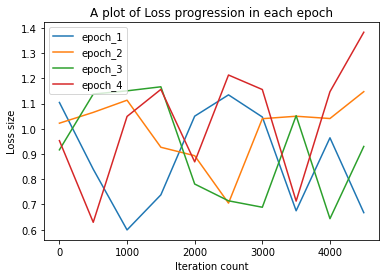

In [ ]:
for i, epoch_losses in enumerate(steps_loss):
  plt.plot(steps_axis, epoch_losses, label=steps_loss_labels[i])

plt.title("A plot of Loss progression in each epoch")
plt.xlabel("Iteration count")
plt.ylabel("Loss size")
plt.legend()
plt.show()

In [ ]:
# Evaluation cycle
print("Evaluating...")
total_samples = len(val)
accurate = 0

with torch.no_grad():
  for i, (image, expected_output) in tqdm(enumerate(eval_image_loader)):
    # optimizer.zero_grad()
    out = res_model(image)
    
    for j, prediction in enumerate(out):
      pred = torch.argmax(prediction)
      if expected_output[j].item() == pred:
        accurate += 1

perc_accuracy = (accurate/total_samples) * 100

print(f"Model accuracy {perc_accuracy} over {total_samples} total evaluation samples")

1it [00:00,  6.23it/s]

Evaluating...


400it [01:02,  6.43it/s]

Model accuracy 84.8 over 2000 total evaluation samples


In [ ]:
print(num_features)

512
